# Vente de voitures

L'industrie automobile est un secteur d'activité economique traditionellement fort en France. La France se place au troisième rang des pays européens pour le nombre d'immatriculations de voitures neuves et plus de la moitié de ces immatriculations concernent des voitures de marque francaises (PSA Peugeot Citroen & Renault).
Curieusement, les ventes de véhicules sont corrélés à la consommation privée et sont a ce titre un bon indicateur de l'acivitée économique du pays.

## 1. Les voitures les plus vendues en France

Nous avons récupéré un jeu de données des voitures les plus vendues en France sur les années 2008 à 2015. Ces données sont disponibles [ici](http://www.fiches-auto.fr/articles-auto/l-auto-en-chiffres/s-651-voitures-les-plus-vendues-en-france.php).
Par commodité, nous avons collecté ces données dans un fichier Excel qui peut être chargé directement (`best_selling_models.xlsx`).

### Exercice 1: Data Viz

** 1.1 Combien d'unitées de voitures sont vendues chaque année ? **


In [2]:
import pandas as pd
#import des feuille excel dans une dataframe
ventes = pd.read_excel("E:/notebooks/best_selling_models.xlsx", 
                       sheetname=["2015","2014","2013","2012","2011", "2010","2009","2008"])


In [5]:
%matplotlib inline
import unicodedata
import matplotlib.pyplot as plt
import seaborn
from matplotlib.pyplot import cm 
from datetime import datetime
import numpy as np
seaborn.set_context("talk")

#Ajout d'un colonne année
for year in range(2008,2016):
    ventes[str(year)]['annee'] = int(year)

#regroupement des différentes années en une seul dataframe
df = pd.concat(ventes)
df.index = range(len(df))

#élimination des caractère accentués ey conversion de date
df.modele = [unicodedata.normalize('NFKD',x).strip().encode('ASCII','ignore') for x in df.modele]
df.annee = [datetime.strptime(str(x), '%Y') for x in df.annee]



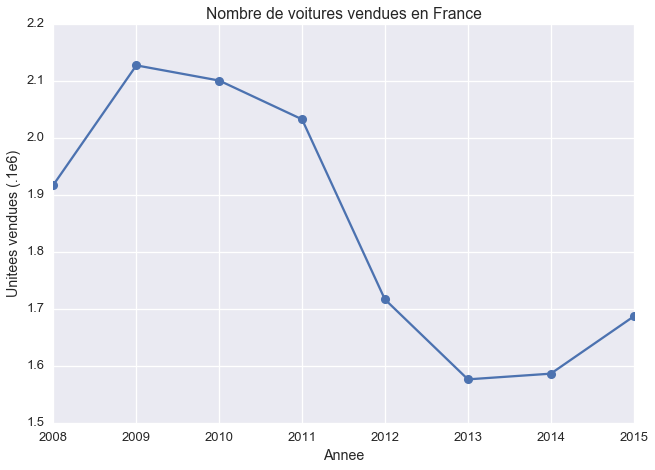

In [7]:
total_unite_vendues = df.groupby('annee', as_index=False).sum()
plt.plot(total_unite_vendues.annee, total_unite_vendues.vente/1e6, '-o')
plt.ylabel('Unitees vendues (.1e6)')
plt.xlabel('Annee')
plt.title('Nombre de voitures vendues en France')
plt.show()

**Comment expliquer cette baisse de ventes à partir de 2011?**

- L'année 2011 est marquée par la fin de **la prime à la casse** qui était conçu pour augmenter les ventes de voitures plus propres et sortir de la circulation les voitures les plus polluantes.
- Une diminution du PIB à partir de 2012 ?

In [8]:
#chiffres insee: http://www.insee.fr/fr/themes/tableau.asp?reg_id=0&id=159
pib = pd.read_excel("NATTEF08112.xls")

#On sélectionne les années 2008 à 2015
annees = pib.ix[61:68,0]
annees = annees.tolist()
#nettoyage de quelques dates
annees[5] = int(annees[5].strip(' (r)'))
annees[6] = int(annees[6].strip(' (r)'))
#conversion au format datetime
annees_DT = [datetime.strptime(str(x), '%Y') for x in annees]
#Sélection des valeurs de pib pour ces années
valeurs = pib.ix[61:68,1]

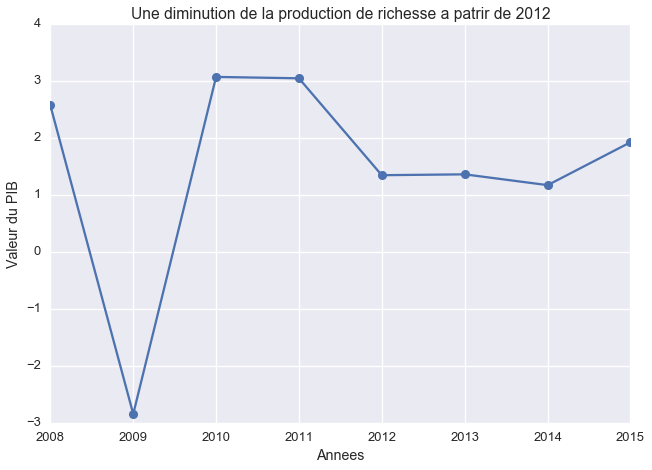

In [9]:
#plot
plt.plot(annees_DT,valeurs.tolist(), 'o-')
plt.xlabel('Annees')
plt.ylabel('Valeur du PIB')
plt.title("Une diminution de la production de richesse a patrir de 2012")
plt.show()

** 1.2 Quels sont les modèles de voitures les plus vendues en France ces dernières années ? **

In [14]:
#recherche du top 3 des modèles pour chaque année
voitures = []
for y in range(2008,2016):
    max_y = df[df['annee'] == str(y)].vente.nlargest(1).tolist()
    v = [df[df['vente'] == x].modele.tolist() for x in max_y]
    voitures.append(v)
#unlist
v = [val[0] for sublist in voitures for val in sublist]
#plot
color=iter(cm.rainbow(np.linspace(0,1,len(set(v)))))

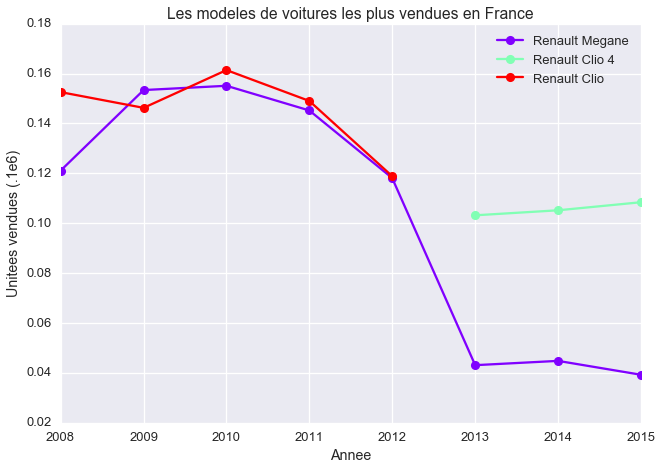

In [15]:
for mod in set(v):
    plt.plot_date(df[df['modele'] == mod].annee,df[df['modele'] == mod].vente/1e6, '-o', label=mod, color=next(color))
plt.legend(loc='best')
plt.title('Les modeles de voitures les plus vendues en France')
plt.xlabel('Annee')
plt.ylabel('Unitees vendues (.1e6)')
plt.show()

## 2. Les différents modèles de voitures vendues en France

A partir de la liste des marques vendue en France (29), nous avons récupéré (scraping) les caractéristiques techniques de chaque modèle de voitures produites par marque. Ces données sont disponibles sur [cars-data](http://www.cars-data.com/fr/). 
[Scrapy](https://scrapy.org/) est un framework Python qui permet de développer des web crawlers. Nous avons développé un crawler pour le site [cars-data](http://www.cars-data.com/fr/) qui a servi à télécharger l'ensemble des modèles de voitures vendues en France (44970).
Ces données semi-structurées ont été stockées au format [json](https://fr.wikipedia.org/wiki/JavaScript_Object_Notation): `carsdata.json`

### Exercice 2: Apprentissage non supervisé

** 2.1 Quelles classes de voitures peut-on identifier à partir de leurs caractéristiques? **




Les variables sont un mélange de variable catégorielles et variables continues. Les algorithmes de clustering tels que ** k-means ** reposent sur une définition de la distance (par exemple euclidienne) qui s'appliquent uniquement aux variables continues. Pour pouvoir inclure les variables catégorielles, on peut utiliser une variation de k-means qui s'appelle ** k-prototypes **.
Les étapes:
1. Imputer les valeurs NaN avec la moyenne de la colonne
2. Standardiser les variables continues
3. Définir une mesure de la qualité de clustering
4. Itérations de k-prototypes avec différents nombres de clusters pour optimiser la mesure de clustering.

** Résultats: **
Les différentes tentatives de clustering ont échouées. Les echantillons sont difficiles à séparer correctement car ont obtient que deux clusters qui est la valeur minimale. Ce qui veut dire que les différents modèles ne sont pas séparables par leur caractéristiques techniques.

In [18]:
import pandas as pd
data = pd.read_csv("carsdata_features.csv", engine='c')
import numpy as np
cat_var = data.select_dtypes(include=['int64'])
cont_var = data.select_dtypes(include=['float64'])

#1. imputer les valeur manquantes
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(np.array(cont_var))
cont_var_array = imp.transform(np.array(cont_var))

#2. Standardiser les variables continues
from sklearn import preprocessing
scaled_cont_var_array = preprocessing.scale(cont_var_array)

seaborn.set_context("notebook")

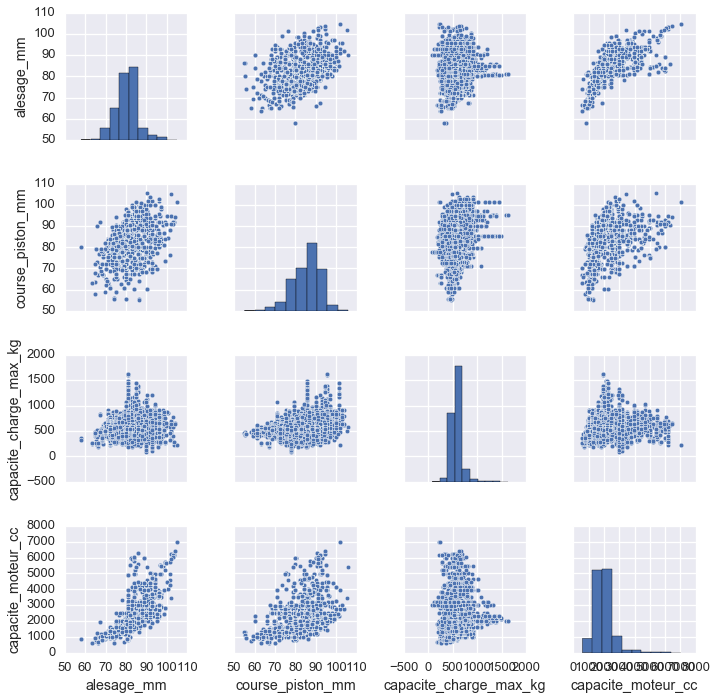

In [23]:
df = pd.DataFrame(cont_var_array)
df.columns = list(cont_var.columns.values)
g = seaborn.pairplot(df.iloc[:,:4])

En se basant sur l'analyse de quelques variables il n'y a pas de séparations visibles entre les modèles.

** 2.2 Quelle est la gamme de prix de chaque classe ? **

In [21]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from matplotlib.pyplot import cm 

data = pd.read_csv("carsdata_features.csv", engine='c')
df = pd.DataFrame()
df["bus"] = data.prix.where(data.bus == 1)/1000
df["cabriolet"] = data.prix.where(data.cabriolet == 1)/1000
df["coupe"] = data.prix.where(data.coupe == 1)/1000
df["hatchback"] = data.prix.where(data.hatchback == 1)/1000
df["mpv"] = data.prix.where(data.mpv == 1)/1000
df["pickup"] = data.prix.where(data.pickup == 1)/1000
df["sedan"] = data.prix.where(data.sedan == 1)/1000
df["stationwagon"] = data.prix.where(data.stationwagon == 1)/1000
df["suv_crossover"] = data.prix.where(data.suv_crossover == 1)/1000

seaborn.set_context("talk")

** Est-ce que le prix de vente d'une voiture neuve est différent en fonction du type de carrosserie? **
Les différents types de carrrosseries sont:

- **`bus`**, 
- **`cabriolet`**, 
- **`coupe`**, 
- **`hatchback`**, 
- **`mpv`**, 
- **`pickup`**, 
- **`sedan`**, 
- **`stationwagon`**, 
- **`suv_crossover`**


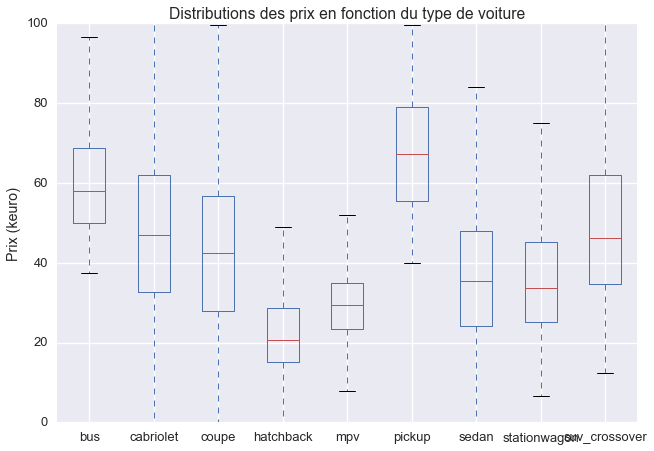

In [22]:
df.plot.box()
plt.ylim(0,100)
plt.ylabel("Prix (keuro)")
plt.title("Distributions des prix en fonction du type de voiture")
plt.show()

Les espaces (mvp) et voitures à hayon (hatchback), c'est à dire les petites voitures 3 ou 5 portes, sont parmis les moins chères. Les plus chères sont les pickups.

# Quels facteurs influencent le plus le prix de vente ?

1. Feature selection
        186  --> 165 features
2. Selection des features qui ont le plus de poids predictif sur le prix (par cross-validation)

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

#selection des echantillons qui ont un prix
filtered_data = data[data.prix.notnull() ]
y = np.array(filtered_data.prix)
X = np.array(filtered_data.drop(["prix",'marque', 'modele', 'version'],axis=1))
#imputeur de valeur manquantes
import numpy as np
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)
#selecteur de variables grâce à un modele de regression linéaire et cross-validation
lr = LinearRegression(n_jobs=-1)
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X,y)
#liste des colones selectionnées
df = filtered_data.drop(["prix",'marque', 'modele', 'version'],axis=1)
selected_features = df.iloc[:,selector.support_].columns.values
#nouvelle matrice
y = np.array(filtered_data.prix)
X = np.array(filtered_data[selected_features])
imp.fit(X)
X = imp.transform(X)


NameError: name 'ElasticNetCV' is not defined

In [25]:
#cross-validation
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], normalize=False,cv=20, n_jobs=-1, eps=5e-3).fit(X,y)

In [26]:
model.l1_ratio_
#1.0
# Le MSE mminimum est obtenu pour un ratio L1 égale à 1. La penalité appliquée est donc L1 (Lasso).

1.0

In [27]:
df_coef = pd.DataFrame({"coefs":model.coef_, "names":list(filtered_data[selected_features].columns.values)})
df_coef.sort_values(by="coefs",ascending=False,inplace=True)
df = df_coef[df_coef.coefs != 0.0 ]

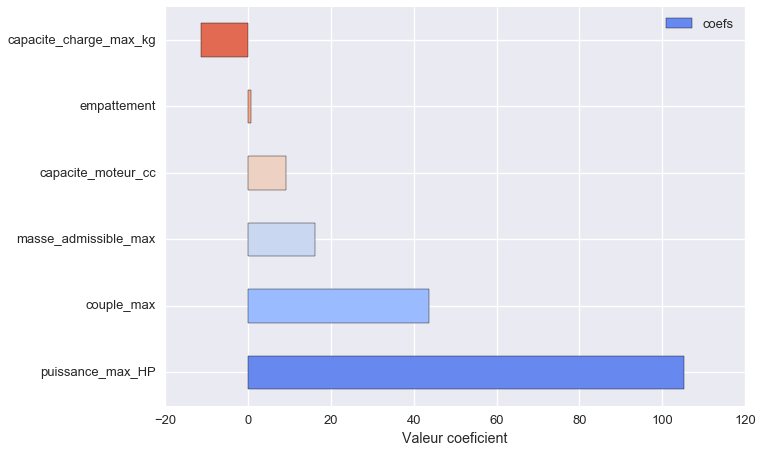

In [28]:
seaborn.set_context("talk")
df.plot("names","coefs",kind="barh", color=seaborn.color_palette("coolwarm"))
plt.xlabel("Valeur coeficient")
plt.ylabel("")
plt.show()

Les caractéristiques techniques qui augmentent le plus avec le prix sont la puissance et le couple du moteur, et dans une moindre mesure le volume du moteur.
On observe aussi que la masse de la voiture augmente avec le prix, mais cette augmentation est annulée si le véhicule est de type utilitaire.